# $pseudo$-VGPs

 APWP based on simulated VGPs (*pseudo*-VGPs) following the approach from Vaes et al. (2022)

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
                               cartesian2spherical, GCD_cartesian)                              
from vgptools.utils_compilation import dfs_vgps_recomputed_poles
from vgptools.utils_APWPs import running_mean_APWP, RM_stats
from vgptools.utils_visualization import  RM_stats, plot_pseudoVGPs_and_APWP, plot_APWP_RM_ensemble, quantiles, plot_pole

Path to the VGP directory.

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

## Generate a DataFrame for both, the VGPs and the recomputed poles by study

In doing so, we calculate a pole for each study taking into account all the vgps within the same area/study

In [3]:
df_filtered_vgps, df_pole_compilation_by_study = dfs_vgps_recomputed_poles(data_path_VGP, by_study = True)

In [4]:
df_pole_compilation_by_study.head()

,Study,pole,N,K,A95,slat,slon,Plat,Plon,min_age,max_age,mean_age
0,Absaroka_volcanics,NaN,44,11.076771,6.774448,44.613899,250.051065,-81.917678,328.57593,45.0,54.0,49.5
1,Beaver_River_intrusions,NaN,21,44.972756,4.792312,60.238151,234.652209,-79.313242,327.669841,40.5,43.5,42.0
2,Bighorn_Basin_sediments,NaN,59,10.64057,5.954672,44.459816,251.809627,-81.549042,2.761738,52.54,59.237,55.8885
3,Bishop_tuff,NaN,47,127.0,1.9,37.67,241.25,-80.164116,314.290252,0.7661,0.7679,0.767
4,Bitterroot_Dome_intrusions,NaN,11,34.082686,7.93379,46.373039,245.107637,-72.178647,344.432968,46.4,55.5,50.95


# Moving average on parametrically resampled vgps ('pseudo vgps')

First we need to generate a new dataset by drawing parametrically from the study-level poles.

In the present formulation the age of each *pseudo*-VGPs, it is taken at random between
the lower and upper bounds of the distribution of reported VGPs.

In [5]:
def get_pseudo_vgps(df):  
    '''
    takes a DF with paleomagnetic poles and respective statistics, it draws N randomly generated VGPs
    following the pole location and kappa concentration parameter. In the present formulation we follow
    a very conservative apporach for the assignaiton of ages to each VGP, it is taken at random between
    the lower and upper bounds of the distribution of reported VGPs.
    Note: column labels are presently hard-coded into this, if relevant.
    '''
    Study, age_bst, vgp_lat_bst, vgp_lon_bst = [], [], [], []

    for index, row in df.iterrows():
        
        # we first generate N VGPs following with N the number of VGPs from the original pole.
        directions_temp = ipmag.fishrot(k = row.K, n = row.N, dec = row.Plon, inc = row.Plat, di_block = False)
        
        vgp_lon_bst.append(directions_temp[0])
        vgp_lat_bst.append(directions_temp[1])
    
        age_bst.append([np.random.randint(np.floor(row.min_age),np.ceil(row.max_age)) for _ in range(row.N)])
        Study.append([row.Study for _ in range(row.N)])
    
    vgp_lon_bst = [item for sublist in vgp_lon_bst for item in sublist]
    vgp_lat_bst = [item for sublist in vgp_lat_bst for item in sublist] 
    age_bst = [item for sublist in age_bst for item in sublist]
    Study = [item for sublist in Study for item in sublist]
    
    dictionary = {
                  'Study': Study,
                  'Plat': vgp_lat_bst,    
                  'Plon': vgp_lon_bst,
                  'mean_age': age_bst
                  }    
    
    pseudo_vgps = pd.DataFrame(dictionary)

    return pseudo_vgps

In [6]:
%%time
df_pseudo_vgps = get_pseudo_vgps(df_pole_compilation_by_study)
df_pseudo_vgps.head(3)

CPU times: user 150 ms, sys: 4.86 ms, total: 155 ms
Wall time: 153 ms


,Study,Plat,Plon,mean_age
0,Absaroka_volcanics,-72.274290,51.940026,47
1,Absaroka_volcanics,-63.239392,311.972469,46
2,Absaroka_volcanics,-66.451347,74.370993,49


# Applying the running mean on the *pseudo*-VGPs
We first apply the running mean method with the same parameter as in Torsvik et al. 2012 - a window lenght of 20 Ma and a time-step of 10 Ma.

In [7]:
min_age = 0
max_age = 65
window_length = 20
time_step = 10

RM_on_pseudoVGP = running_mean_APWP (df_pseudo_vgps, "Plon", "Plat", "mean_age", window_length, time_step, max_age, min_age)
RM_on_pseudoVGP.head(3)

,age,N,n_studies,k,A95,csd,plon,plat
0,0.0,317.0,15.0,23.071921,1.680560,16.863322,-58.434496,-88.019599
1,10.0,411.0,18.0,18.831681,1.641161,18.665537,-42.274298,-86.846974
2,20.0,264.0,9.0,11.586950,2.660118,23.795808,-20.663376,-82.016385


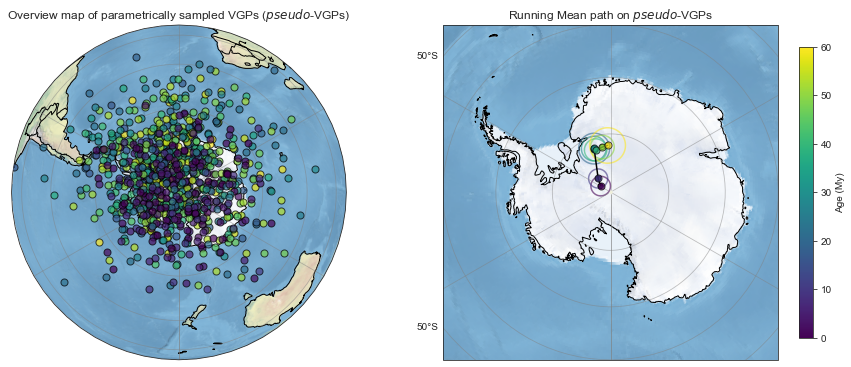

In [8]:
extent = [-180,180,-60,-60]
plot_pseudoVGPs_and_APWP(extent, df_pseudo_vgps, RM_on_pseudoVGP)

### Bootstrapped age distribution

<AxesSubplot:title={'center':'Bootstrapped age distribution'}, xlabel='Mean Age', ylabel='Number of $pseudo$-VGPs'>

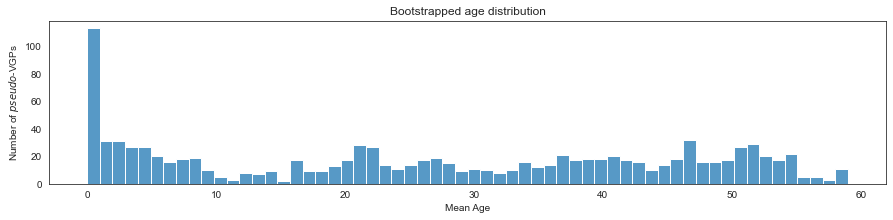

In [9]:
fig = plt.figure(figsize=(15,3))
plt.title('Bootstrapped age distribution')
plt.ylabel('Number of $pseudo$-VGPs')
plt.xlabel('Mean Age')
sns.histplot(data = df_pseudo_vgps, x = 'mean_age', bins = 60, legend = False) 

### Running Mean Statistics

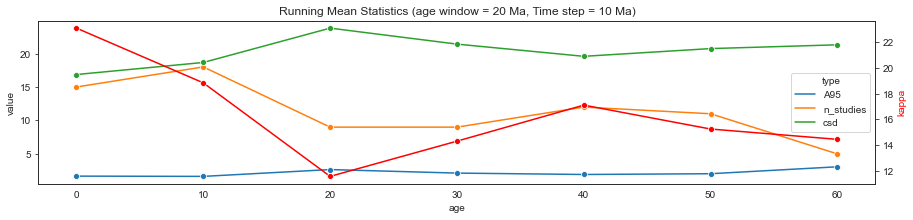

In [10]:
RM_stats(RM_on_pseudoVGP, f"Running Mean Statistics (age window = {window_length} Ma, Time step = {time_step} Ma)","Age (Ma)","kappa")

# APWP confidence bounds

Because we are taking a Monte Carlo approach, confidence on the mean cannot be assessed from one iteration. To generate confidence bounds on the APWP, we will apply the same approach a number of times in order to construct an ensemble of possible solutions that will allow us to construct empirical confidence bounds.

In [11]:
%%time
df_parametric_means_collection = pd.DataFrame(columns=['run','n_studies','k','A95','csd'])

for i in range(100):
    
    pseudo_vgps_temp = get_pseudo_vgps(df_pole_compilation_by_study)
    RM_APWP_parametric_temp = pd.DataFrame()
    RM_APWP_parametric_temp = running_mean_APWP(pseudo_vgps_temp, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)
    RM_APWP_parametric_temp['run'] = i
    df_parametric_means_collection = df_parametric_means_collection.append(RM_APWP_parametric_temp, ignore_index=True)

df_parametric_means_collection['plon'] = df_parametric_means_collection.apply(lambda row: row.plon - 360 if row.plon > 180 else row.plon, axis =1)    

CPU times: user 16.8 s, sys: 86.9 ms, total: 16.9 s
Wall time: 16.9 s


In [12]:
RM_ensemble_quant_plat = quantiles(df_parametric_means_collection,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_ensemble_quant_plon = quantiles(df_parametric_means_collection,"age","plon") # set quantiles of longitude groupedby age for visualization purposes

In [13]:
df_parametric_means_collection.head(5)

,run,n_studies,k,A95,csd,age,N,plon,plat
0,0,15.0,24.440554,1.65184,16.38436,0.0,309.0,-52.813462,-87.069247
1,0,18.0,18.941091,1.65443,18.611549,10.0,402.0,-25.143080,-86.453534
2,0,9.0,10.37729,2.682206,25.144502,20.0,293.0,-23.136853,-81.320775
3,0,9.0,12.589969,2.225823,22.828254,30.0,344.0,-32.469056,-81.445310
4,0,12.0,18.506844,1.838108,18.828635,40.0,334.0,-20.190714,-82.562782


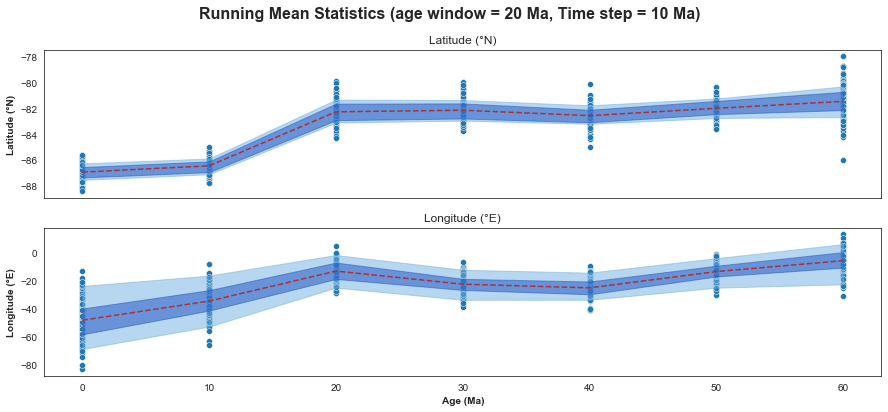

In [14]:
plot_APWP_RM_ensemble(df_parametric_means_collection, f"Running Mean Statistics (age window = {window_length} Ma, Time step = {time_step} Ma)")

## Example path

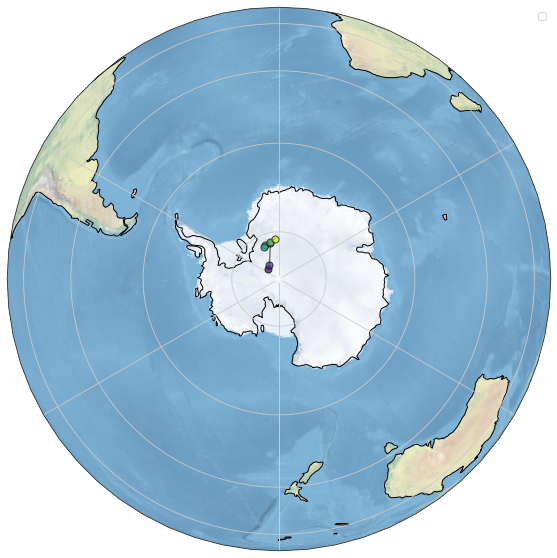

In [15]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic
from shapely.geometry import Polygon


fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()


# sns.scatterplot(x = RM_ensembl_quant_plon.mean, y =RM_ensemble_quant_plat.mean,
                
#                 transform = ccrs.PlateCarree())
plt.plot(RM_ensemble_quant_plon.mean, RM_ensemble_quant_plat.mean,transform = ccrs.Geodetic(), color = "black", alpha = 0.5)

for i in zip(RM_ensemble_quant_plat.mean, RM_ensemble_quant_plon.mean, df_parametric_means_collection['age'].unique().transpose()):
    plot_pole(i[0],i[1],i[2],0,65,ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()